In [1]:
from langchain.chat_models import init_chat_model

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [54]:
from langchain.chat_models import init_chat_model

# Replace 'llama3-8b-8192' with the specific Groq model you want to use
llm = init_chat_model("groq:qwen/qwen3-32b")

llm.invoke("test line")

AIMessage(content='<think>\nOkay, so I need to figure out how to respond to this user who wrote "test line." Let me start by understanding what they might be asking for. The message is pretty short, so maybe they\'re just testing if the system is working. But maybe they want me to elaborate on my thought process for handling such a prompt.\n\nFirst, I should acknowledge that the user wrote "test line." But since there\'s no specific question or context, I should probably ask for clarification. However, the user mentioned that in the initial example, the assistant provided a detailed thought process. So maybe they want me to simulate that here, even though the input is minimal.\n\nLet me break down my possible responses. If the user\'s input is vague, my job is to generate a helpful and detailed thought process. So I should consider different angles: maybe they want to test the system\'s responsiveness, check if the model is working, or see how I handle ambiguous queries. \n\nI should a

## **Building Agent without MCP**

In [4]:
## Search tools
import getpass

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [5]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [62]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-120b")

In [63]:
llm_with_tools =llm.bind_tools([search_tool], tool_choice="any") 

In [64]:
response =llm_with_tools.invoke("can you tell me the current weather of khulna.") 

In [65]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fc_181fad3b-d261-4265-afef-eea92686bcd8', 'function': {'arguments': '{"include_images":false,"query":"current weather Khulna","search_depth":"basic","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 119, 'prompt_tokens': 846, 'total_tokens': 965, 'completion_time': 0.236848353, 'prompt_time': 0.038585037, 'queue_time': 0.047243483, 'total_time': 0.27543339}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--232f7b3f-623a-42e7-84e3-14bd72f828bc-0', tool_calls=[{'name': 'tavily_search', 'args': {'include_images': False, 'query': 'current weather Khulna', 'search_depth': 'basic', 'topic': 'general'}, 'id': 'fc_181fad3b-d261-4265-afef-eea92686bcd8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 846, 'output_tokens': 119, 'total_tokens': 965})

In [66]:
response.tool_calls

[{'name': 'tavily_search',
  'args': {'include_images': False,
   'query': 'current weather Khulna',
   'search_depth': 'basic',
   'topic': 'general'},
  'id': 'fc_181fad3b-d261-4265-afef-eea92686bcd8',
  'type': 'tool_call'}]

In [67]:
tools_msg = search_tool.invoke(response.tool_calls[0]["args"])

In [68]:
tools_msg

{'query': 'current weather Khulna',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Weather in Khulna',
   'url': 'https://www.weatherapi.com/',
   'content': "{'location': {'name': 'Khulna', 'region': '', 'country': 'Bangladesh', 'lat': 22.8, 'lon': 89.55, 'tz_id': 'Asia/Dhaka', 'localtime_epoch': 1755884791, 'localtime': '2025-08-22 23:46'}, 'current': {'last_updated_epoch': 1755884700, 'last_updated': '2025-08-22 23:45', 'temp_c': 25.7, 'temp_f': 78.3, 'is_day': 0, 'condition': {'text': 'Light rain shower', 'icon': '//cdn.weatherapi.com/weather/64x64/night/353.png', 'code': 1240}, 'wind_mph': 4.5, 'wind_kph': 7.2, 'wind_degree': 207, 'wind_dir': 'SSW', 'pressure_mb': 1002.0, 'pressure_in': 29.6, 'precip_mm': 0.35, 'precip_in': 0.01, 'humidity': 92, 'cloud': 88, 'feelslike_c': 29.3, 'feelslike_f': 84.7, 'windchill_c': 25.7, 'windchill_f': 78.3, 'heatindex_c': 29.3, 'heatindex_f': 84.7, 'dewpoint_c': 24.4, 'dewpoint_f': 75.9, 'vis_km': 10.0, 'vis_

## **Build the simple agent with Tools**

In [69]:
from langgraph.graph import StateGraph, MessagesState, START, END

class AgentState(MessagesState):
    pass

In [70]:
def assistant(state: AgentState):
    print("---Assistant---")
    # The 'messages' in the state is a list. The last message is the current input.
    messages = state['messages']
    print(f"Current messages: {messages}")
    
    # Invoke the LLM with the current conversation history
    response = llm_with_tools.invoke(messages) 
    
    # LangGraph expects you to return a list of messages to append to the state
    return {
        "messages": [response]
    }

In [71]:
tools = [search_tool]

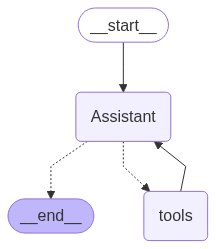

In [72]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(AgentState)

builder.add_node("Assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "Assistant")
builder.add_conditional_edges(
    "Assistant",
    tools_condition
)
builder.add_edge("tools", "Assistant")
app = builder.compile()

app

In [73]:
from langchain_core.messages import HumanMessage
app.invoke(
    {
        "messages": [HumanMessage(content="can you tell me the current weather of khulna.")]
    }
)

---Assistant---
Current messages: [HumanMessage(content='can you tell me the current weather of khulna.', additional_kwargs={}, response_metadata={}, id='f447a9e1-ad5e-428f-b867-aa59481815c0')]
---Assistant---
Current messages: [HumanMessage(content='can you tell me the current weather of khulna.', additional_kwargs={}, response_metadata={}, id='f447a9e1-ad5e-428f-b867-aa59481815c0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fc_2e9851d3-705b-4da0-afd5-32055fed22e5', 'function': {'arguments': '{"query":"current weather Khulna","search_depth":"advanced","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 846, 'total_tokens': 942, 'completion_time': 0.192933015, 'prompt_time': 0.03100329, 'queue_time': 0.047175337, 'total_time': 0.223936305}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='ru

BadRequestError: Error code: 400 - {'error': {'message': 'Tool choice is required, but model did not call a tool', 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '**Current weather in Khulna (as of\u202f7:42\u202fPM\u202flocal time,\u202f22\u202fAugust\u202f2025)**  \n\n| Parameter | Value |\n|-----------|-------|\n| **Temperature** | **≈\u202f80\u202f°F** (≈\u202f27\u202f°C) |\n| **Condition** | Light showers – overcast |\n| **Feels like** | 84\u202f°F (≈\u202f29\u202f°C) |\n| **Wind** | 8\u202fmph, from the **north‑east** (↑) |\n| **Humidity** | **91\u202f%** |\n| **Chance of rain** | 45\u202f% |\n| **Precipitation (last hour)** | 0.03\u202fin rain (≈\u202f0.8\u202fmm) |\n\nThese details come from the hourly forecast on TimeandDate.com, which was last refreshed at **7:42\u202fPM** on\u202f22\u202fAugust\u202f2025 for Khulna Division, Bangladesh【0†source】.'}}